# Домашнее задание №8

    1) Выберите зависимую переменную и не менее 7 независимых переменных (можно выбрать больше). Обратите внимание, что есть переменные, оценивающие один и тот же индикатор, но рассчитанные по-разному. Не нужно их одновременно включать в модель.
    2) Сформулируйте гипотезы о наличии взаимосвязей между зависимой и независимыми переменными.
    3) Проведите описательный анализ данных.
    4) Проведите тесты для выбора одной из трёх моделей: объединённая модель панельных данных, модель с фиксированными эффектами и модель со случайными эффектами. Выберите подходящую модель и обоснуйте свой выбор.
    5) Опишите полученную модель в целом.
    6) Подробно опишите взаимосвязи между зависимой переменной и предикторами.
    7) Сформулируйте общие выводы по результатам анализа.

## Чтение и предварительная обработка данных

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS, RandomEffects, PooledOLS
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Worldbank_panel.xlsx')
year = pd.Categorical(df.year)
df = df.set_index(["id", "year"]) #создаём двухуровневый индекс
df["year"] = year
df.head(5)

v1         v2       v3          v4         v5         v6  \
id      year                                                                    
Albania 2015        NaN        NaN      NaN    39699.53   242870.0   8.402315   
        2016        NaN    26634.0    306.0    30279.78   266379.0   9.228641   
        2017        NaN   204090.0   1904.0    53273.59   303612.0  10.526845   
        2018   0.000000   303137.0   2935.0    13648.00   361947.0  12.555659   
Algeria 2015  21.901645  5400896.0  65940.0  1635509.00  2269348.0   5.712209   

                   v7        v8        v9         v10  ...          v30  \
id      year                                           ...                
Albania 2015   226718  7.843521  1.634190  16607486.0  ...  3952.802538   
        2016   248640  8.614077  0.784313  10199913.0  ...  4090.371657   
        2017   246720  8.554284  0.088457   1119016.0  ...  4249.803734   
        2018   248631  8.624815  0.044702    591717.0  ...  4431.539181   
Algeria 2015  3267592  8.224904  0.233281   2549728.0  ...  4177.889542   

                    v31        v32        v33        v34        v35       v36  \
id      year                                                                    
Albania 2015   8.194605  80.694759  11.110635  27.267391  44.533615  4.896312   
        2016   7.769623  80.961061  11.269315  28.977899  45.831964  4.916017   
        2017   8.893543  79.608056  11.498401  31.569808  46.624466  5.012636   
        2018   9.605795  79.107646  11.286560  31.571927  45.236191  5.232072   
Algeria 2015  37.429177  41.010477  21.560346  23.171778  36.523351  6.978489   

               v37     v38  year  
id      year                      
Albania 2015   9.6  78.025  2015  
        2016   9.4  78.194  2016  
        2017   9.4  78.333  2017  
        2018   9.5  78.458  2018  
Algeria 2015  25.2  76.090  2015  

[5 rows x 39 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360 entries, ('Albania', 2015) to ('Zambia', 2018)
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   v1      329 non-null    float64 
 1   v2      338 non-null    float64 
 2   v3      338 non-null    float64 
 3   v4      307 non-null    float64 
 4   v5      359 non-null    float64 
 5   v6      359 non-null    float64 
 6   v7      360 non-null    int64   
 7   v8      360 non-null    float64 
 8   v9      342 non-null    float64 
 9   v10     350 non-null    float64 
 10  v11     351 non-null    float64 
 11  v12     352 non-null    float64 
 12  v13     354 non-null    float64 
 13  v14     354 non-null    float64 
 14  v15     338 non-null    float64 
 15  v16     316 non-null    float64 
 16  v17     323 non-null    float64 
 17  v18     360 non-null    float64 
 18  v19     360 non-null    float64 
 19  v20     352 non-null    float64 
 20  v21     351 non-null    f

Из 39 колонок у нас ненулевые только 18. Попробуем немного расширить этот список.

Так как средние значения слишком неусточивы к выбросам, то заполнять средними по столбцу слишком опрометчивое решение. Можно заполнять средним по группе (в нашем случае, по конкретной стране. То есть мы берем конкретную колонку для конкретной станы и все пустые значения заполняем средними - так более логично)

In [4]:
df_not_null = df.copy() # создадим копию датафрейма, чтобы попробовать убрать часть пустых значений
for column in df_not_null.columns: # пройдем по всем столбцам
    if df_not_null[column].isnull().any():  # проверяем, есть ли пропуск в столбце
        df_not_null[column] = df_not_null.groupby('id')[column].transform(lambda x: x.fillna(x.mean())) # заполняем средним ПО ГРУППЕ значением

In [5]:
df_not_null.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360 entries, ('Albania', 2015) to ('Zambia', 2018)
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   v1      344 non-null    float64 
 1   v2      348 non-null    float64 
 2   v3      348 non-null    float64 
 3   v4      308 non-null    float64 
 4   v5      360 non-null    float64 
 5   v6      360 non-null    float64 
 6   v7      360 non-null    int64   
 7   v8      360 non-null    float64 
 8   v9      352 non-null    float64 
 9   v10     360 non-null    float64 
 10  v11     360 non-null    float64 
 11  v12     360 non-null    float64 
 12  v13     356 non-null    float64 
 13  v14     356 non-null    float64 
 14  v15     356 non-null    float64 
 15  v16     340 non-null    float64 
 16  v17     344 non-null    float64 
 17  v18     360 non-null    float64 
 18  v19     360 non-null    float64 
 19  v20     360 non-null    float64 
 20  v21     360 non-null    f

После заполнения пропусков у нас 25 столбцов с непустыми значениями. Будем пользоваться этим датасетом.

## Выбор зависимой и независимых переменных.

Выбранные предикторы:
    
    v6 - Количество абонентов фиксированной широкополосной связи (на 100 человек) - "Fixed broadband subscriptions (per 100 people)";

    v11 - Экспорт товаров в сфере ИКТ (% от общего объема экспорта товаров) - "ICT goods exports (% of total goods exports)";

    v18 - Подписки на мобильную сотовую связь - "Mobile cellular subscriptions";
    
    v23 - Защищенные интернет-серверы - "Secure Internet servers";
    
    v32 - Расходы домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП) - Households and NPISHs final consumption expenditure (% of GDP);
    
    v33 - Государственные расходы на конечное потребление (% от ВВП) - "General government final consumption expenditure (% of GDP)";

    year - Год - "Year".


Зависимая переменная:
    
    v35 - Импорт товаров и услуг (% от ВВП) - "Imports of goods and services (% of GDP)".

### Описание независимых переменных

In [8]:
df_not_null['year_str'] = df_not_null['year'].astype(str) 
# добавим столбец с годом-строкой, чтобы на графиках отобразить ежегодное изменение 
# (если не ввполнить это, то на горизонтальной оси годы отображаются как: 2015, 2015.5, 2016, 2016.5 и т.д.)

#### V6 - Количество абонентов фиксированной широкополосной связи (на 100 человек)

In [6]:
df_not_null['v6'].describe()

count    360.000000
mean      18.846134
std       13.313221
min        0.066192
25%        7.213224
50%       16.623617
75%       30.273268
max       46.319901
Name: v6, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Среднее количество абонентов фиксированной широкополосной связи на 100 человек составляет примерно 19 человек;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 13,31, что указывает на разброс данных между странами;
4. Самое низкое значение количества абонентов на 100 человек составляет 0,066 (оооочень странное значение, ведь это даже не 1 человек.... как говорится, "полтора землекопа" - понятно, что значение получают делением, но нельзя же так считать количество пользователей..странно);
5. 25% (Первый квартиль) наблюдений имеют значение меньше 7 человек;
6. 50% (Второй квартиль, медиана) наблюдений имеют значение меньше 17 человек. Это значение также показывает, что  "центр" данных находится ближе к нижней границе диапазона;
7. 75% (Третий квартиль) наблюдений имеют значение меньше 30 человек;
8. Максимальное количество абонентов фиксированной широкополосной связи на 100 человек составляет 46 человек.

<Axes: xlabel='year_str'>

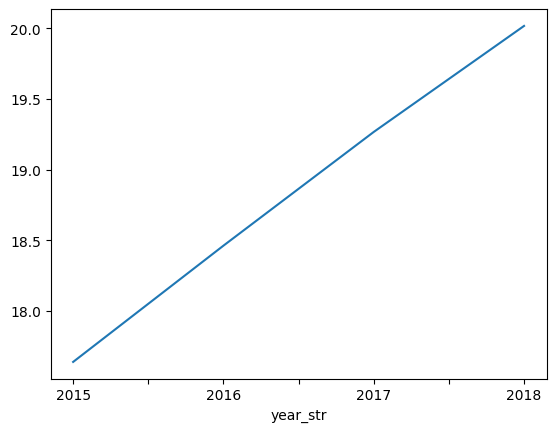

In [9]:
# Группировка по году и построение графика
df_not_null.groupby('year_str')['v6'].mean().plot()

На данном графике представлена динамика среднего значения количества абонентов фиксированной широкополосной связи на 100 человек по годам за период с 2015 по 2018 гг. По нему видно, что количество абонентов фиксированной широкополосной связи на 100 человек увеличивается с каждым годом. Если в 2015 году данный показатель составлял примерно 17 человек, то в 2018 году он составляет 20 человек.

<Axes: >

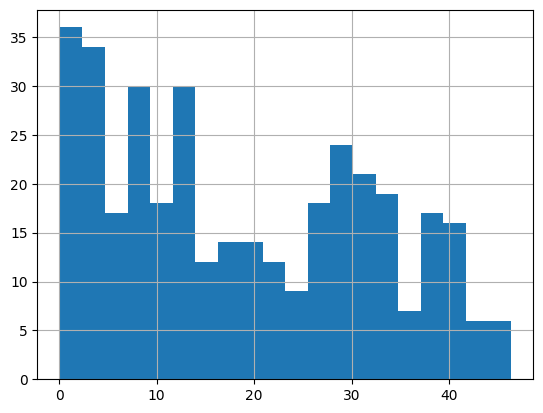

In [10]:
df_not_null['v6'].hist(bins=20)

На данной гистограмме распределения количества абонентов фиксированной широкополосной связи можно сказать следующее:
- Большинство анализируемых стран (примерно половина) имеют относительно небольшое количество абонентов фиксированной широкополосной связи на 100 чел. (от 0 до 14). Это видно по высокой плотности столбцов в левой части гистограммы;
- Примерно 1/4 часть анализируемых стран имеет малое количество абонентов фиксированной широкополосной связи на 100 чел. (от 15 до 25 и от 35 до 46);
- Оставшаяся четвертая часть анаизируемых стран имеет среднее количество абонентов фиксированной широкополосной связи на 100 чел. (от 25 до 34);
- На распределение данных видна ассиметрия, положительная. Это означает, что значения отклоняются от среднего значения преимущественно вправо.

#### V11 - Экспорт товаров в сфере ИКТ (% от общего объема экспорта товаров)

In [11]:
df_not_null['v11'].describe()

count    360.000000
mean       5.044318
std        8.179829
min        0.002003
25%        0.280674
50%        1.730687
75%        4.957045
max       43.214604
Name: v11, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Средний процент экспорта товаров в сфере ИКТ от общего объема экспорта составляет примерно 5,04%;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 8,18, что указывает на разброс процента экспорта в сфере ИКТ в зависимости от страны;
4. Самое низкое значение доли экспорта ИКТ исоставляет 0,002%;
5. 25% (Первый квартиль) наблюдений имеют значение ниже 0,28%;
6. 50% (Второй квартиль, медиана) наблюдений имеют значение ниже 1,73%;
7. 75% (Третий квартиль) наблюдений имеют значение ниже 4,96%;
8. Максимальное значение экспорта товаров в сфере ИКТ составляет 43,21%.

<Axes: xlabel='year_str'>

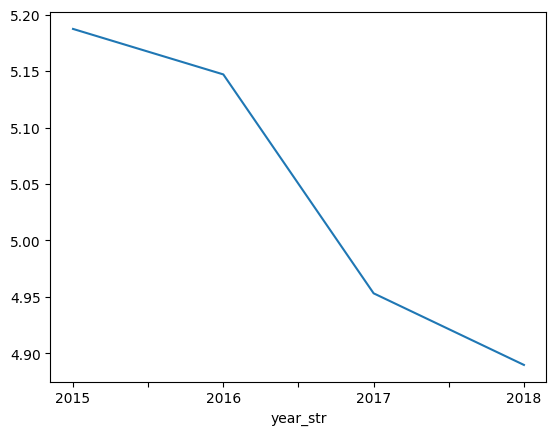

In [12]:
df_not_null.groupby('year_str')['v11'].mean().plot()

На данном графике представлена динамика среднего значения экспорта товаров в сфере ИКТ по годам за период с 2015 по 2018 гг. По нему видно, что данный показатель ежегодно снижаетая. Если в 2015 году среднее значение составляло примерно 5,2%, то в 2018 оно состоавляет 4,9%.

<Axes: >

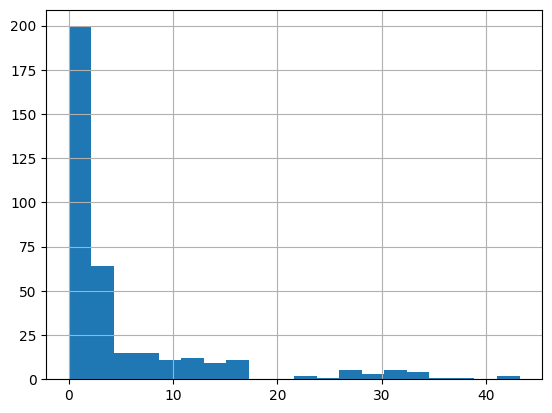

In [13]:
df_not_null['v11'].hist(bins=20)

По гистограмме распределения экспорта товаров в сфере ИКТ (в % от общего объема экспорта) можно сказать следующее:
- Большинство стран имеют относительно небольшой объем экспорта товаров в сфере ИКТ (от 0 до 5%), относительно общего объема экспорта. Это видно по высокой плотности столбцов в левой части гистограммы;
- Небольшое количество стран имеет высокое значение экспорта товаров в сфере ИКТ (в % от общего объема экспорта) - выше среднего. Это видно по длинному правому хвосту распределения;
- Распределение данных является сильно асимметричным, ассиметрия положительная.

#### V18 - Подписки на мобильную сотовую связь

In [14]:
df_not_null['v18'].describe()

count    3.600000e+02
mean     7.179882e+07
std      1.979845e+08
min      3.839190e+05
25%      6.988685e+06
50%      1.263132e+07
75%      5.874746e+07
max      1.649302e+09
Name: v18, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Среднее количество подписок на мобильную связь составляет около 71 798 820 единиц;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 197 984 500 единиц, что указывает на сильный разброс количества подписок на мобильную связь между странами;
4. Минимальное количество подписок составляет 383 919;
5. 25% (Первый квартиль) наблюдейний имеюют менее 6 988 685 подписок;
6. 50% (Второй квартиль, медиана) наблюдений имеют менее 12 631 320 подписок;
7. 75% (Третий квартиль) наблюдений имеют значение ниже 58 747 460 подписок;
8. Максимальное количество подписок составляет 1 649 302 000 единиц.

<Axes: xlabel='year_str'>

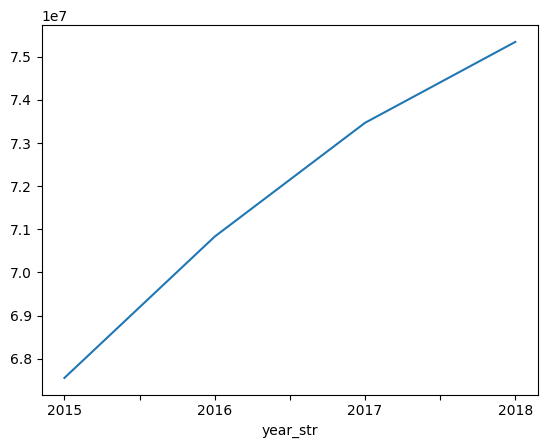

In [15]:
df_not_null.groupby('year_str')['v18'].mean().plot()

На данном графике представлена динамика среднего значения количества подписок на мобильную сотовую связь по годам за период с 2015 по 2018 гг. По нему видно, что количество подписок на мобильную сотовую связь ежегодно растет. Если в 2015 году данный показатель, в среднем, составлял примерно 68 млн. человек, то в 2018 году, в среднем, он составляет 75 млн. человек.

<Axes: >

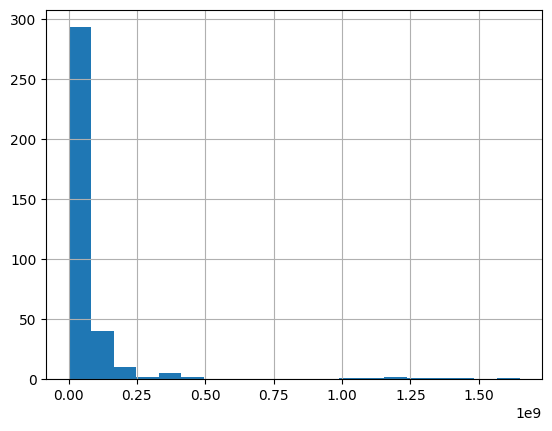

In [16]:
df_not_null['v18'].hist(bins=20)

По гистограмме распределения подписок на мобильную сотовую связь можно сделать следующий вывод:

- Большинство стран имеют относительно небольшое количество подписок на мобильную сотовую связь (до 100 млн. подписок). Это видно по высокой плотности столбцов в левой части гистограммы;
- Малое количество стран имеет значительно большее количество подписок на мобильную сотовую связь (выше, чем 100 млн. подписок), чем среднее значение. Это видно по длинному правому хвосту гистограммы;
- Распределение данных является сильно асимметричным, наблюдается положительная ассиметрия.

#### V23 - Защищенные интернет-серверы

In [17]:
df_not_null['v23'].describe()

count    3.600000e+02
mean     2.278746e+05
std      1.306352e+06
min      2.900000e+01
25%      1.291250e+03
50%      1.337450e+04
75%      9.447500e+04
max      2.151700e+07
Name: v23, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Среднее количество защищенных интернет-сервисов составляет около 227 874 единиц;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 1 306 352 единиц, что указывает на сильный разброс количества защищенных интернет-сервисов между странами;
4. Минимальное количество защищенных серверов составляет 29 единиц;
5. 25% (Первый квартиль) наблюдений имеюют менее 1 291 единиц защищенных серверов;
6. 50% (Второй квартиль, медиана) наблюдений имеют менее 13 374 единиц защищенных серверов;
7. 75% (Третий квартиль) наблюдений имеют значение ниже 94 475 единиц защищенных серверов;
8. Максимальное защищенных серверов составляет 21 517 000 единиц (есть предположение, что это выброс).

<Axes: xlabel='year_str'>

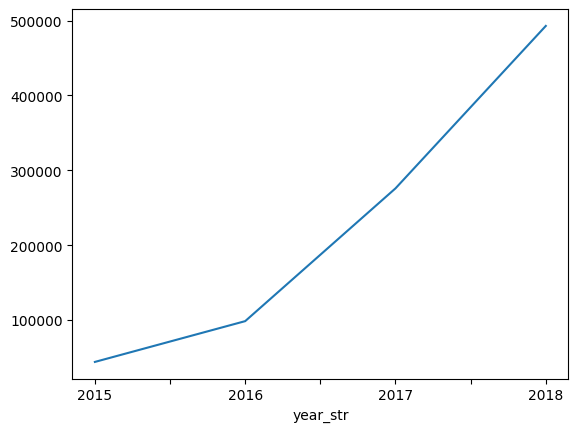

In [18]:
df_not_null.groupby('year_str')['v23'].mean().plot()

На данном графике представлена динамика среднего значения количества защищенных интернет-серверов по годам за период с 2015 по 2018 гг. По нему видно, что количество защищенных интернет-серверов ежегодно растет. Если в 2015 году данный показатель, в среднем, составлял примерно 30 тыс.единиц, то в 2018 году, в среднем, он составляет 500 тыс.единиц.

<Axes: >

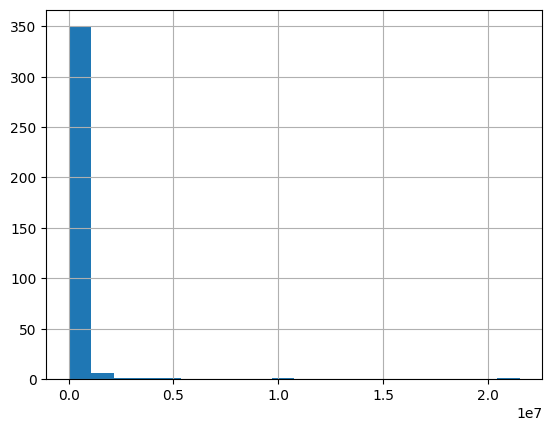

In [19]:
df_not_null['v23'].hist(bins=20)

По данной гистограмме распределения защищенных интернет-серверов можно сделать следующие выводы:

- Большинство стран имеют небольшое количество защищенных интернет-серверов (до 2 млн. единиц). Это видно по высокой плотности столбцов в левой части гистограммы;
- Совсем малое количество стран имеет значительно большее количество защищенных серверов, чем среднее значение. Это видно по длинному правому хвосту гистограммы;
- Распределение данных является сильно асимметричным, наблюдается положительная асимметрия.

#### V32 - Расходы домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП)

In [20]:
df_not_null['v32'].describe()

count    360.000000
mean      61.021945
std       12.213620
min       30.468048
25%       52.568273
50%       60.072920
75%       69.011018
max       90.546573
Name: v32, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Средний уровень расходов домашних хозяйств и некоммерческих организаций на конечное потребление составляет примерно 61,02% от ВВП;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 12,21%, что указывает на высокий разброс данных между странами;
4. Минимальный уровень потребления составляет 30,47% от ВВП;
5. 25% (Первый квартиль) наблюдений имеют уровень потребления менее 52,57% от ВВП;
6. 50% (Второй квартиль, медиана) наблюдений имеют уровень потребления менее 60,07% от ВВП;
7. 75% (Третий квартиль) наблюдений имеют уровень потребления менее 69,01% от ВВП;
8. Максимальный уровень потребления составляет 90,55% от ВВП.


<Axes: xlabel='year_str'>

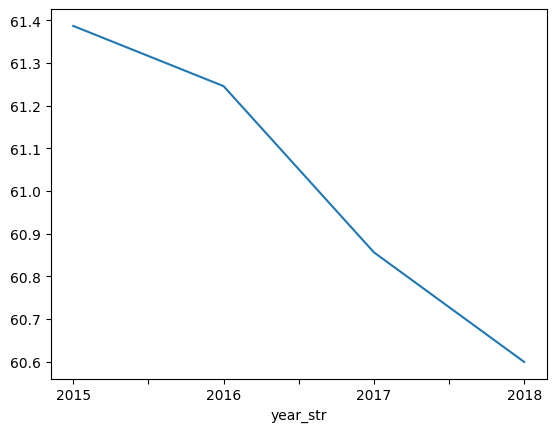

In [21]:
df_not_null.groupby('year_str')['v32'].mean().plot()

На данном графике представлена динамика среднего значения расходов домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП) по годам за период с 2015 по 2018 гг. По нему видно, что расходы домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП) ежегодно снижается. Если в 2015 году данный показатель, в среднем, составлял примерно 61,4%, то в 2018 году, в среднем, он составляет 60,6%.

<Axes: >

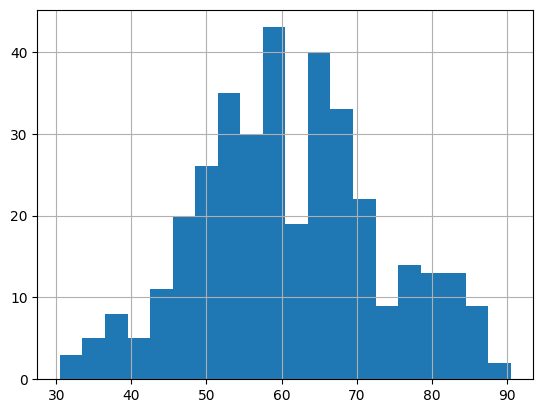

In [22]:
df_not_null['v32'].hist(bins=20)

По гистограмме распределения расходов домашних хозяйств и некоммерческих организаций на конечное потребление (в % от ВВП) можно сделать следующий вывод:

- Распределение данных похоже на нормальное, однако заметен четкий провал в самом центре. Это означает, что большинство стран имеют средний уровень расходов домашних хозяйств и некоммерческих организаций на конечное потребление (в % от ВВП), а значения, сильно отклоняющиеся от среднего, встречаются реже;
- Пик гистограммы приходится на значения около 60%. Это говорит о том, что средний уровень расходов домашних хозяйств и некоммерческих организаций на конечное потребление в нашей выборке составляет примерно 60% от ВВП;
- Данные разбросаны, что видно по ширине и высоте гистограммы. Это говорит о том, что между странами существуют значительные различия в уровне распределения расходов домашних хозяйств и некоммерческих организаций на конечное потребление (в % от ВВП).

#### V33 - Государственные расходы на конечное потребление (% от ВВП)

In [23]:
df_not_null['v33'].describe()

count    360.000000
mean      16.417940
std        4.616302
min        4.926273
25%       13.196605
50%       16.367364
75%       19.375953
max       27.228583
Name: v33, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Средний уровень государственных расходов на конечное потребление составляет примерно 16,42% от ВВП;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 4,62%, что указывает на сильный разброс данных между странами;
4. Минимальный уровень государственных расходов на конечное потребление составляет 4,93% от ВВП;
5. 25% (Первый квартиль) наблюдений имеют уровень государственных расходов на конечное потребление менее 13,20% от ВВП;
6. 50% (Второй квартиль, медиана) наблюдений имеют уровень государственных расходов на конечное потребление менее 16,37% от ВВП;
7. 75% (Третий квартиль) наблюдений имеют уровень государственных расходов на конечное потребление менее 19,38% от ВВП;
8. Максимальный уровень государственных расходов на конечное потребление составляет 27,23% от ВВП.

<Axes: xlabel='year_str'>

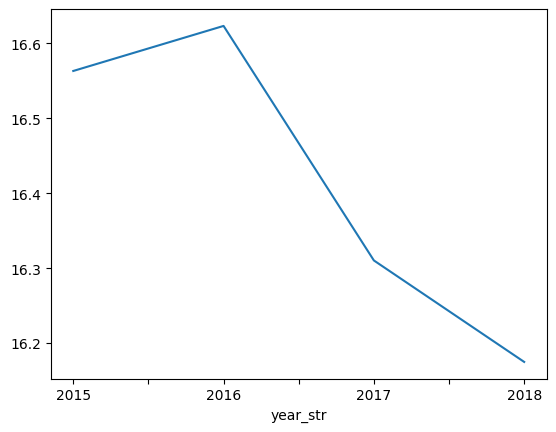

In [24]:
df_not_null.groupby('year_str')['v33'].mean().plot()

На данном графике представлена динамика государственных расходов на конечное потребление (% от ВВП) по годам за период с 2015 по 2018 гг. По графику кривой видно, что данный показатель изменялся скачкообразно, но за последние годы у него имеется тенденция к снижению. Если в 2015 году данный показатель, в среднем, составлял примерно 16,55%, а в 2016 году, в среднем, около 16,65%, то в 2018 году, средний показатель скнизился до 16,2%.

<Axes: >

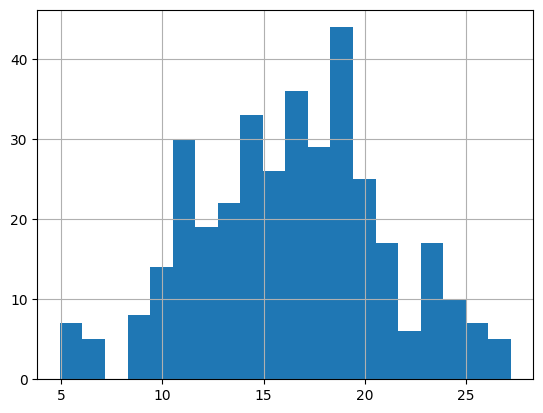

In [25]:
df_not_null['v33'].hist(bins=20)

По гистограмме распределения государственных расходов на конечное потребление можно сделать следующие выводы:

- Распределение данных схоже с нормальным, но имеютя скачки. Это означает, что большинство стран имеют средний уровень государственных расходов на конечное потребление, а значения, сильно отклоняющиеся от среднего, встречаются реже;
- Пик гистограммы приходится на значения около 18-20%. Это говорит о том, что средний уровень государственных расходов на конечное потребление в нашей выборке составляет примерно 18-20% от ВВП;
- Данные разбросаны, что видно по ширине и высоте гистограммы. Это говорит о том, что между странами существуют значительные различия в уровне государственных расходов на конечное потребление.

### Описание зависимой переменной

#### V35 - Импорт товаров и услуг (% от ВВП)

In [6]:
df_not_null['v35'].describe()

count    360.000000
mean      45.566729
std       24.469239
min        0.683885
25%       28.448951
50%       42.082358
75%       57.216309
max      151.086790
Name: v35, dtype: float64

По полученному описанию мы видим:
1. В выбранных данных нет пустых значений (360 из 360 значений);
2. Средний уровень импорта товаров и услуг составляет примерно 45,57% от ВВП;
3. Стандартное отклонение (разброс данных относительно среднего значения) составляет 24,47%, что указывает на сильный разброс данных между странами;
4. Минимальный уровень импорта товаров и услуг составляет 0,68% от ВВП;
5. 25% (Первый квартиль) наблюдений имеют уровень импорта товаров и услуг менее 28,45% от ВВП;
6. 50% (Второй квартиль, медиана) наблюдений имеют уровень импорта товаров и услуг менее 42,08% от ВВП;
7. 75% (Третий квартиль) наблюдений имеют уровень импорта товаров и услуг менее 57,22% от ВВП;
8. Максимальный уровень импорта товаров и услуг составляет 151,09% от ВВП.

<Axes: xlabel='year_str'>

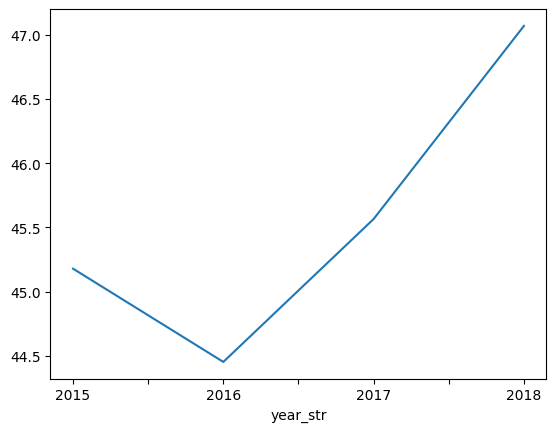

In [58]:
df_not_null.groupby('year_str')['v35'].mean().plot()

На данном графике представлена уровня импорта товаров и услуг (% от ВВП) по годам за период с 2015 по 2018 гг. По графику кривой видно, что данный показатель изменялся скачкообразно, но за последние годы у него имеется тенденция к росту. Если в 2015 году данный показатель, в среднем, составлял примерно 45,25%, а в 2016 году, в среднем, около 44,5%, то в 2018 году, средний показатель вырос до 47%.

<Axes: >

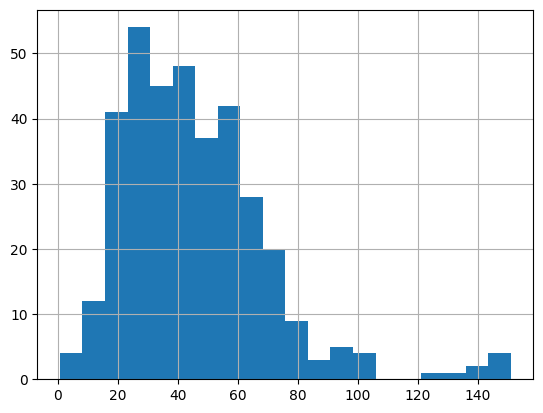

In [105]:
df_not_null['v35'].hist(bins=20)

По гистограмме распределения государственных расходов на конечное потребление можно сделать следующие выводы:

- Большая часть анализируемых стран (более 2/3) имеет уровень импорта товаров и услуг (в % от ВВП) от 10% до 70%;
- Оставшаяся часть стран имеет уровень испорта товаров и услуг (в % от ВВП) от 0 до 10% и от 70% до 150%;
- Данные разбросаны, что видно по ширине и высоте гистограммы. Это говорит о том, что между странами существуют значительные различия в уровне государственных расходов на конечное потребление;
- По графику прослеживается положительная ассиметрия в распределении. 


### Гипотезы о наличии взаимосвязей между зависимой и независимыми переменными
1)  Существует взаимосвязь между количеством абонентов фиксированной широкополосной связи (на 100 человек) и импортом товаров и услуг (% от ВВП);
2) Существует взаимосвязь между экспортом товаров в сфере ИКТ (% от общего объема экспорта товаров) и импортом товаров и услуг (% от ВВП);
3) Существует взаимосвязь между подпиской на мобильную сотовую связь и импортом товаров и услуг (% от ВВП);
4) Существует взаимосвязь между Защищенные интернет-серверы и импортом товаров и услуг (% от ВВП);
5) Существует взаимосвязь между расходами домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП) и импортом товаров и услуг (% от ВВП);
6) Существует взаимосвязь между государственными расходами на конечное потребление (% от ВВП) и импортом товаров и услуг (% от ВВП);
7) Существует взаимосвязь между годом и импортом товаров и услуг (% от ВВП).

### Корреляция переменных в полученном датасете

<Axes: >

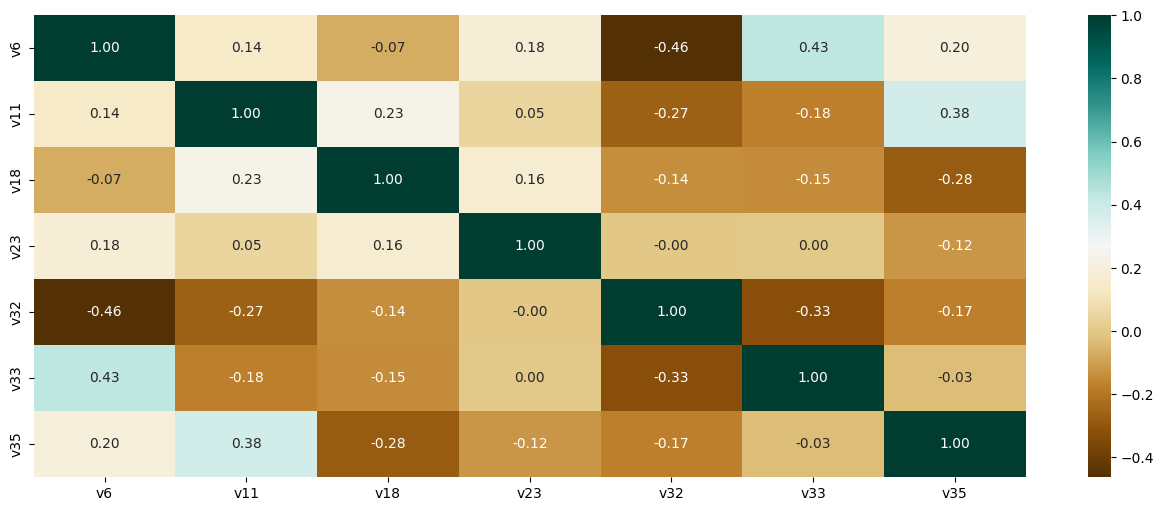

In [7]:
predictors_list = ["v6", "v11", "v18", "v23", "v32", "v33"]
target = "v35"

corr_matrix = df_not_null[predictors_list + [target]].corr()
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, cmap='BrBG', annot=True,fmt=".2f")

По полученным значениям корреляций мы видим, что сильной положительной или отрицательной корреляции не наблюдается, значит, можно строить модель, понимая, что она действительно будет находить зависимости в данных, а не опираться на сильно влияющие значения.

Из данной матрица корреляций мы исключили значения колонки "Год", так как она является категориальной и корреляция Пирсона не подходит.

Чтобы рассчитать корреляцию между категориальной и числовой переменными воспользуемся корееляцией Спирмена.

In [8]:
from scipy.stats import spearmanr

corr= spearmanr(df_not_null['year'], df_not_null['v35'])
print(f"Корреляция Спирмена между годом и импортом товаров и услуг (% от ВВП) = {corr[0]}")

Корреляция Спирмена между годом и импортом товаров и услуг (% от ВВП) = 0.03868216808990922


### Выводы по гипотезам

<span style='color:Red'> 

1) Корреляция между количеством абонентов фиксированной широкополосной связи (на 100 человек) и импортом товаров и услуг (% от ВВП) равна 0,20, что говорит об очень слабой корреляции между переменными - гипотеза не подтверждается;
2) Корреляция между экспортом товаров в сфере ИКТ (% от общего объема экспорта товаров) и импортом товаров и услуг (% от ВВП) равна 0,38, что говорит о слабой корреляции между переменными - гипотеза не подтверждается;
3) Корреляция между подпиской на мобильную сотовую связь и импортом товаров и услуг (% от ВВП) равна -0,28, что говорит о слабой обратной корреляции между переменными - гипотеза не подтверждается;
4) Корреляция между Защищенные интернет-серверы и импортом товаров и услуг (% от ВВП )равна -0,12, что говорит об очень слабой обратной корреляции между переменными - гипотеза не подтверждается;
5) Корреляция между расходами домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП) и импортом товаров и услуг (% от ВВП) равна -0,17, что говорит об очень слабой обратной корреляции между переменными - гипотеза не подтверждается;
6) Корреляция между государственными расходами на конечное потребление (% от ВВП) и импортом товаров и услуг (% от ВВП) равна -0,03, что говорит об очень слабой обратной корреляции между переменными - гипотеза не подтверждается;
7) Корреляция между годом и импортом товаров и услуг (% от ВВП) равна 0,04, что говорит об очень слабой корреляции между переменными - гипотеза не подтверждается. 
</span>

## Выбор модели панельных даннных

### Объединенная модель панельных данных (Pooled model)

#### Начнем с объединенной модели панельных данных. Это обычная линейная регрессия, учитывающая панельную структуру данных. В качестве зависимой переменной - импорт товаров и услуг (% ВВП). В качестве предикторов - остальные переменные и дамми-переменные за каждый год.

In [9]:
exog = sm.add_constant(df_not_null[predictors_list + ["year"]])
mod = PooledOLS(df_not_null[target], exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    v35   R-squared:                        0.3218
Estimator:                  PooledOLS   R-squared (Between):              0.3319
No. Observations:                 360   R-squared (Within):              -0.3848
Date:                Mon, Nov 25 2024   R-squared (Overall):              0.3218
Time:                        01:10:15   Log-likelihood                   -1591.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      18.456
Entities:                          90   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(9,350)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             18.456
                            

#### Проводим Breusch-Pagan тест. 
Фактически, мы выясняем есть ли индивидуальные эффекты.

##### Тест Бреуша — Пагана позволяет сделать выбор между моделью со случайными эффектами и обычной регрессией пула (объединенная модель панельных данных), которая не учитывает никаких индивидуальных эффектов. Нулевая гипотеза этого теста состоит в том, что дисперсия случайных эффектов равна нулю. Если это так, то в применении доступного обобщенного метода наименьших квадратов (модель, учитывающая эффекты) нет необходимости, и можно ограничиться обычным методом наименьших квадратов (бъединенная модель панельных данных) без учета случайных эффектов.

Источник [https://books.econ.msu.ru/Introduction-to-Econometrics/chap09/9.7/]

In [10]:
from statsmodels.stats.diagnostic import het_breuschpagan
residuals_pooled_OLS = pooled_res.resids #сохраняем остатки
pooled_OLS_dataset = pd.concat([df_not_null, residuals_pooled_OLS], axis=1) #добавляем остатки в исходный датасет
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
print('P-value:', breusch_pagan_test_results[3])

P-value: 3.295563551248072e-14


#####  Гипотеза H0: нет индивидуальных эффектов 

##### Мы отвергаем H0, поскольку p-value < 0,05 

### Соответственно, мы выяснили, есть индивидуальные эффекты, а значит <span style='color:Orange'> <b> нужна модель с эффектами (случайными или фиксированными). </b> </span>

### Модель панельных данных с фиксированными эффектами (Fixed effects model)

In [11]:
from linearmodels.panel import PanelOLS

exog = sm.add_constant(df_not_null[predictors_list + ["year"]])
mod = PanelOLS(df_not_null[target], exog, entity_effects=True)
fe_res = mod.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    v35   R-squared:                        0.1490
Estimator:                   PanelOLS   R-squared (Between):              0.0119
No. Observations:                 360   R-squared (Within):               0.1490
Date:                Mon, Nov 25 2024   R-squared (Overall):              0.0138
Time:                        01:10:21   Log-likelihood                   -864.97
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.0774
Entities:                          90   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(9,261)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             5.0774
                            

### Модель панельных данных со случайными эффектами (Random effects model)

In [12]:
from linearmodels.panel import RandomEffects

mod = RandomEffects(df[target], exog)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    v35   R-squared:                        0.1442
Estimator:              RandomEffects   R-squared (Between):              0.1994
No. Observations:                 360   R-squared (Within):               0.1225
Date:                Mon, Nov 25 2024   R-squared (Overall):              0.1983
Time:                        01:10:23   Log-likelihood                   -925.60
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.5501
Entities:                          90   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(9,350)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             6.5501
                            

### Сравниваем модель со случайными и c фиксированными эффектами.

#### Проводим тест Хаусмана

##### В рамках теста сравниваются оценки модели с фиксированными эффектами, полученные при помощи внутригруппового преобразования, и оценки модели со случайными эффектами, полученные при помощи доступного обобщенного метода наименьших квадратов (ОМНК). Нулевая гипотеза теста Хаусмана в данном случае состоит в том, что оценки доступного ОМНК являются состоятельными. Альтернативная гипотеза — в том, что они несостоятельны. Если нулевая гипотеза отвергается, то следует заключить, что оценки доступного ОМНК несостоятельны, и сделать выбор в пользу модели с фиксированными эффектами. В противном случае предпочтительной является модель со случайными эффектами.

Источник [https://books.econ.msu.ru/Introduction-to-Econometrics/chap09/9.7/]

In [13]:
import numpy.linalg as la
from scipy import stats
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('p-value: ' + str(hausman_results[2]))

p-value: 0.007725884226962128


#### Гипотеза H0: индивидуальные эффекты и регрессоры не коррелируют

#### Поскольку p-value < 0.05 H0 отклоняем, что говорит нам о том, что индивидуальные эффекты и регрессоры коррелируют.

### В рамках полученных результатов, мы <span style='color:Green'> <b> выбираем модель с фиксированными эффектами </b> </span>

### Описание полученной модели в целом.

В результате построения модели были рассмотрены данные по 90 странам (Entities = 90), в каждой из которых было по 4 наблюдения (min, max obs.);

R-квадрат (between) = 0,0119, что является низким значением, указывающим на слабую объясняемость данных между странами;

R-квадрат (within) = 0,1490, что также является низким значением и указывает на слабую объяснимость данных внутри каждой страны;

R-квадрат (overall) = 0,0138 говорит о том, что модель объясняет только 1,38% вариации зависимой переменной;

Полученное значение p-value показывает, что модель статистически значима (< 0,05).

### Подробно опишите взаимосвязи между зависимой переменной и предикторами.


#### На 5% уровне значимости выявлено лишь 2 предиктора.
#### Рассмотрим показатели, являющиеся статистически значимыми на уровне 10%:

1) <b> Количество абонентов фиксированной широкополосной связи (на 100 человек). </b> Данный показатель имеет p-value = 0,0893 и является статистически значимым на 10% уровне. При изменении количества абонентов фиксированной широкополосной связи (на 100 человек) на 1 единицу - импорт товаров и услуг (% от ВВП) вырастает на 0,3076% (в данном случае % - это единица измерения самого показателя импорта товаров и услуг);

2) <b> Государственные расходы на конечное потребление (% от ВВП). </b> Данный показатель имеет p-value = 0,0063 и является статистически значимым, как на 5%, так и на 10% уровне. При изменении государственных расходов на конечное потребление (% от ВВП) на 1 единицу - импорт товаров и услуг (% от ВВП) вырастает на 0,4202% (в данном случае % - это единица измерения самого показателя импорта товаров и услуг);

Мы должны обратить внимание, что в исходном датасете имеются данные за 4 года - 2015, 2016, 2017, 2018. А в полученной модели имеется только 3 года - 2016, 2017, 2018. Соответственно, можно сделать вывод, что 2015 год выбран автоматически в качестве референтной группы, а значит, интерпретировать результаты необходимо с учетом этой информации.

3) <b> 2016 год. </b> Данный показатель имеет p-value = 0,0800 и является статистически значимым на 10% уровне. Значение коэффициента при данном показателе равно -0,8639 - это значит, что в 2016 году во всех странах, по сравнению с 2015 годом Импорт товаров и услуг (% от ВВП) выше на 0,08% (в данном случае % - это единица измерения самого показателя импорта товаров и услуг);

4) <b> 2018 год. </b> Данный показатель имеет p-value = 0,0241 и является статистически значимым, как на 5%, так и на 10% уровне. Значение коэффициента при данном показателе равно 1,5232 - это значит, что в 2018 году во всех странах, по сравнению с 2015 годом Импорт товаров и услуг (% от ВВП) выше на 1,5232% (в данном случае % - это единица измерения самого показателя импорта товаров и услуг).

### Сформулируйте общие выводы по результатам анализа.

Для прогнозирования импорта товаров и услуг (% от ВВП) были выбраны данные по 90 странам за 4 года (с 2015 по 2018 гг.). В качестве предикторов были выбраны следующие переменные:

- Количество абонентов фиксированной широкополосной связи (на 100 человек);
- Экспорт товаров в сфере ИКТ (% от общего объема экспорта товаров);
- Подписки на мобильную сотовую связь;
- Защищенные интернет-серверы;
- Расходы домашних хозяйств и некоммерческих организаций на конечное потребление (% от ВВП);
- Государственные расходы на конечное потребление (% от ВВП);
- Год (с 2015 по 2018 гг.).

У выбранных предикторов не нормальное распределение, а также практически у всех наблюдается довольно-таки высокое средне квадратическое отклонение. Аналогично и с зависимой переменной.

Перед построением модели были выдвинуты гипотезы, что все предикторы взаимосвязаны с таргетной переменной. Однако, по полученной матрице корреляций ни одна из гипотез не подтвердилась. 

После построения объединенной модели панельных данных и проведения теста Бреуша — Пагана было выявлено, что для имеющихся даннных необходимо использовать модель с эффектами.

После построения двух моделей панельных данных - со случайными и фиксированными эффектами, а также после проведения теста Хаусмана было выявлено, что для имеющихся данных подходит модель с фиксированными эффектами.

Полученная модель имеет низкие значения R-квадрата (особенно для between вариации), что  указывать на то, что модель объясняет лишь небольшую долю вариации зависимой переменной. Однако статистическая значимость модели указывает на то, что она является значимой.

На 5% уровне значимости получилось всего 2 статистически значимых пердиктора - государственные расходы на конечное потребление (% от ВВП) и 2018 год.

А на уровне 10% значимости добавилось еще 2 статистически значимых предиктора - количество абонентов фиксированной широкополосной связи (на 100 человек) и 2016 год. Оставшиеся предикторы не являются статистически значимыми.

В заключении хотелось бы отметить, что полученную модель можно улучшить, например, удалить статистически не значимые предикторы, попробовать добавить другие предикторы, а также поискать выбросы и поработать с ними.